In [2]:
# Install the required packages
install.packages("readr")
install.packages("dplyr")
install.packages("knitr")
install.packages("e1071")
install.packages("ggplot2")
install.packages("ggridges")
install.packages("gridExtra")
install.packages("rlang")
install.packages("corrplot")
install.packages("gplots")

# Load the required packages
library(rlang)
library(readr)
library(dplyr)
library(knitr)
library(e1071)
library(gridExtra)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

also installing the dependency 'vroom'


Warning message in install.packages("readr"):
"installation of package 'vroom' had non-zero exit status"
Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)


Attaching package: 'dpl

In [3]:
# Load the data
data_raw <- read.csv("WCGS.csv", sep = ";")

# Select the relevant columns
data_raw <- select(data_raw, chd, age, height, weight, sbp, dbp, chol, ncigs)

# Print the data_raw
print(summary(data_raw))

      chd             age            height          weight         sbp       
 Min.   :1.000   Min.   :39.00   Min.   :60.00   Min.   : 78   Min.   : 98.0  
 1st Qu.:2.000   1st Qu.:42.00   1st Qu.:68.00   1st Qu.:155   1st Qu.:120.0  
 Median :2.000   Median :45.00   Median :70.00   Median :170   Median :126.0  
 Mean   :1.919   Mean   :46.28   Mean   :69.78   Mean   :170   Mean   :128.6  
 3rd Qu.:2.000   3rd Qu.:50.00   3rd Qu.:72.00   3rd Qu.:182   3rd Qu.:136.0  
 Max.   :2.000   Max.   :59.00   Max.   :78.00   Max.   :320   Max.   :230.0  
                                                                              
      dbp              chol           ncigs     
 Min.   : 58.00   Min.   :103.0   Min.   : 0.0  
 1st Qu.: 76.00   1st Qu.:197.2   1st Qu.: 0.0  
 Median : 80.00   Median :223.0   Median : 0.0  
 Mean   : 82.02   Mean   :226.4   Mean   :11.6  
 3rd Qu.: 86.00   3rd Qu.:253.0   3rd Qu.:20.0  
 Max.   :150.00   Max.   :645.0   Max.   :99.0  
                  NA's   

In [4]:
# This section is dedicated to the data cleaning
# Data cleaning steps:

# 1. Convert the data types
#   1.1 Convert chd to a binary variable (1 = yes, 2 = no -> 1 = yes, 0 = no)
#   1.2 Convert height and weight to metric units (inch to cm, lbs to kg)

# 2. Handle the missing values according to the variable
#   2.1 If the variable is binary, replace the missing values with the mode
#   2.2 If the variable is continuous check for normality:
#     2.2.1 If normally distributed, replace with the mean
#     2.2.2 If not normally distributed, replace with the median

# 3. Check for outliers and handle them accordingly using the IQR method
#   3.1 If the variable is binary, replace the outliers with the mode
#   3.2 Calculate the 10th and 90th percentiles for continuous variables
#     3.2.1 Replace the outliers with the 10th or 90th percentile accordingly

In [5]:
# Function to convert the data types
convert_chd <- function(data) {
  data$chd <- ifelse(data$chd == 1, 1, 0)
  return(data)
}

convert_units <- function(data) {
  data$height <- data$height * 2.54  # Convert inches to cm
  data$weight <- data$weight * 0.453592  # Convert lbs to kg
  return(data)
}

In [6]:
# Functions to handle missing values
replace_missing_binary <- function(data) {
  binary_columns <- sapply(data, is.factor)
  for (col in names(data)[binary_columns]) {
    mode <- names(sort(table(data[[col]]), decreasing = TRUE))[1]
    data[[col]][is.na(data[[col]])] <- mode
  }
  return(data)
}

handle_missing_continuous <- function(data) {
  continuous_columns <- sapply(data, is.numeric)
  for (col in names(data)[continuous_columns]) {
    if (shapiro.test(data[[col]])$p.value > 0.05) {
      mean_val <- mean(data[[col]], na.rm = TRUE)
      data[[col]][is.na(data[[col]])] <- mean_val
    } else {
      median_val <- median(data[[col]], na.rm = TRUE)
      data[[col]][is.na(data[[col]])] <- median_val
    }
  }
  return(data)
}

# Function to call the missing data handling functions
handle_missing_data <- function(data) {
  data <- replace_missing_binary(data)
  data <- handle_missing_continuous(data)
  return(data)
}

In [7]:
# Function to handle outliers
handle_outliers <- function(data) {
  for (col in names(data)) {

    # Exclude the chd column from outlier detection
    if (col != "chd" && is.numeric(data[[col]])) {
      q1 <- quantile(data[[col]], 0.10)
      q3 <- quantile(data[[col]], 0.90)
      iqr <- q3 - q1
      lower_bound <- q1 - 1.5 * iqr
      upper_bound <- q3 + 1.5 * iqr
      data[[col]][data[[col]] < lower_bound] <- lower_bound
      data[[col]][data[[col]] > upper_bound] <- upper_bound
    }

    # In the chd column replace values other than 0 and 1 with the mode value
    if (col == "chd") {
      mode_chd <- as.numeric(names(which.max(table(data$chd))))
      data$chd[data$chd != 0 & data$chd != 1] <- mode_chd
    }
  }

  return(data)
}

In [8]:
# This section is dedicated to the visualization of the data
# Data visualization steps:

# 1. Generate a stacked bar plot for the binary variable
# 2. Generate an histogram and density plot for each continuous variable
#   2.1 Print all the plots in a grid

In [9]:
# Functions to generate the plot for the binary variable
library(ggplot2)

# Function to count the occurrences of the binary variable
count_binary_occurrences <- function(data, col) {
  # Count the occurrences of CHD (1) and no CHD (0)
  positive_count <- sum(data[[col]] == 1)
  negative_count <- sum(data[[col]] == 0)

  # Return the counts
  return(list(positive_count = positive_count, negative_count = negative_count))
}

generate_stacked_bar_plot <- function(data, col) {

  # Count the occurrences of the binary variable
  counts <- count_binary_occurrences(data, col)

  # Create a data frame for the bar plot
  bar_data <- data.frame(
    category = c(col, paste("No", col)),  # Rename the categories
    count = c(counts$positive_count, counts$negative_count)
  )

  # Define the colors for the bar plot
  colors <- c("#7ED9D9", "#FBBAB5")
  col <- toupper(col)

  # Generate the stacked bar plot
  plot <- ggplot(bar_data, aes_string(x = "''", y = "count",
                                      fill = "category")) +
    geom_bar(stat = "identity", width = 1) +
    scale_fill_manual(values = colors) +
    geom_text(aes_string(label = "count"),
              position = position_stack(vjust = 0.5), size = 5) +
    labs(
      title = paste(col, "Distribution"),
      x = paste("Total population =",
                counts$positive_count + counts$negative_count),
      y = "Frequency"
    ) +
    theme_minimal() +
    theme(
      legend.position = "right",
      plot.title = element_text(hjust = 0.5, margin = margin(t = 10)),
      plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm")
    ) +
    guides(fill = guide_legend(title = NULL))  # Remove the legend name

  return(plot)
}

In [10]:
# Functions to generate the plot for the continous variables
library(ggplot2)

# Function to generate the histogram
generate_histogram <- function(data, col) {
  data_range <- range(data[[col]])

  n_bins <- 30
  binwidth <- diff(data_range) / n_bins
  binwidth <- max(1, binwidth)

  # Generate the histogram
  plot <- ggplot(data, aes_string(x = col)) +
    geom_histogram(binwidth = binwidth, fill = "#7ED9D9", color = "#201717") +
    labs(
      title = paste("Histogram of ", toupper(col)),
      x = col,
      y = "Frequency"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, margin = margin(t = 10)),
      plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm")
    )

  return(plot)
}

In [11]:
# Load necessary libraries
library(ggplot2)
library(ggridges)

# Function to generate the density plot
generate_density_plot <- function(data, col) {
  # Generate the density plot
  plot <- ggplot(data, aes_string(x = col, y = "0",
                                  fill = "after_stat(density)")) +
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01) +
    scale_fill_gradient(low = "#7ED9D9", high = "#FBBAB5") +
    labs(
      title = paste("Density Plot of", toupper(col)),
      x = col,
      y = "Density"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, margin = margin(t = 10)),
      plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
      legend.position = "none"  # Remove the legend
    )

  return(plot)
}

In [12]:
# This section is dedicated to the data correlation analysis
# Data correlation analysis steps:

# Focus on the correlation between the continuous variables and chd
# 1. Calculate the correlation between the continuous variables and chd
#   1.1 Calculate the correlation coefficient
#     1.1.1 Pearson correlation coefficient if normally distributed
#     1.1.2 Spearman correlation coefficient if not normally distributed
# 2. Generate a density plots to overlay data from patients with and without chd
# 3. Generate a box plot to overlay data from patients with and without chd

In [42]:
generate_pearson_report <- function(data, continuous_var) {
  # Perform the correlation test
  cor_test <- cor.test(data[[continuous_var]], data$chd)

  return(cor_test)
}


In [13]:
library(ggplot2)
library(dplyr)
library(rlang)

# Function to generate the overlayed density plot
generate_double_density_plot <- function(data, col) {
  # Recode the 'chd' column
  data <- data %>%
    mutate(chd = recode(.data$chd, `0` = "no chd", `1` = "chd"))

  # Generate the overlayed density plot
  plot <- ggplot(data, aes_string(x = col, fill = "factor(chd)")) +
    geom_density(alpha = 0.5) +
    labs(
      title = paste("Density Plot of", toupper(col), "by CHD Status"),
      x = col,
      y = "Density",
      fill = NULL  # Remove the legend title
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, margin = margin(t = 10)),
      plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
      legend.position = "right"
    )

  return(plot)
}

In [14]:
library(ggplot2)
library(dplyr)
library(rlang)

# Function to generate the overlayed box plot
generate_double_box_plot <- function(data, col) {
  # Recode the 'chd' column
  data <- data %>%
    mutate(chd = recode(.data$chd, `0` = "no chd", `1` = "chd"))

  # Generate the overlayed box plot
  plot <- ggplot(data, aes_string(x = "factor(chd)",
                                  y = col, fill = "factor(chd)")) +
    geom_boxplot(alpha = 0.5) +
    labs(
      title = paste("Box Plot of", toupper(col), "by CHD Status"),
      x = "CHD Status",
      y = col,
      fill = NULL  # Remove the legend title
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, margin = margin(t = 10)),
      plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
      legend.position = "right"
    )

  return(plot)
}

In [15]:
# Apply the data conversion functions
data_fixed <- convert_chd(data_raw)
data_fixed <- convert_units(data_fixed)

# Apply the missing data handling functions
data_fixed <- handle_missing_data(data_fixed)

# Apply the outlier handling function
data_fixed <- handle_outliers(data_fixed)

In [16]:
# Print the cleaned data
print(summary(data_fixed))

      chd               age            height          weight      
 Min.   :0.00000   Min.   :39.00   Min.   :152.4   Min.   : 35.38  
 1st Qu.:0.00000   1st Qu.:42.00   1st Qu.:172.7   1st Qu.: 70.31  
 Median :0.00000   Median :45.00   Median :177.8   Median : 77.11  
 Mean   :0.08148   Mean   :46.28   Mean   :177.2   Mean   : 77.08  
 3rd Qu.:0.00000   3rd Qu.:50.00   3rd Qu.:182.9   3rd Qu.: 82.55  
 Max.   :1.00000   Max.   :59.00   Max.   :198.1   Max.   :122.47  
      sbp             dbp              chol           ncigs      
 Min.   : 98.0   Min.   : 58.00   Min.   :103.0   Min.   : 0.00  
 1st Qu.:120.0   1st Qu.: 76.00   1st Qu.:198.0   1st Qu.: 0.00  
 Median :126.0   Median : 80.00   Median :223.0   Median : 0.00  
 Mean   :128.6   Mean   : 82.01   Mean   :226.3   Mean   :11.59  
 3rd Qu.:136.0   3rd Qu.: 86.00   3rd Qu.:252.8   3rd Qu.:20.00  
 Max.   :202.0   Max.   :130.00   Max.   :437.5   Max.   :75.00  


Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
i Please use tidy evaluation idioms with `aes()`.
i See also `vignette("ggplot2-in-packages")` for more information."


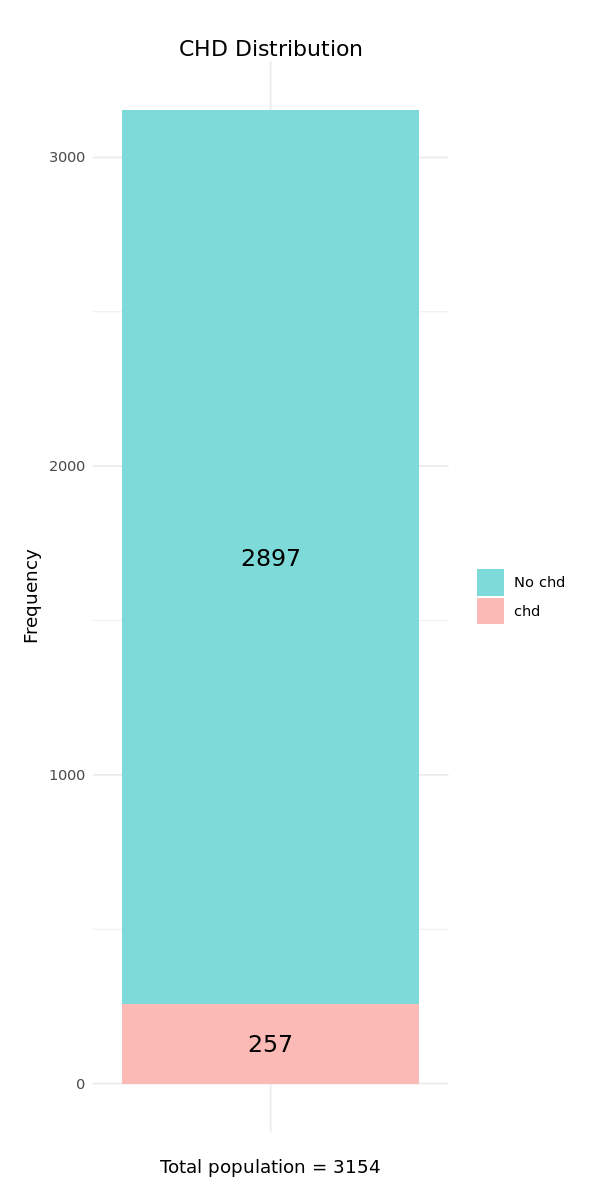

In [17]:
options(repr.plot.width = 5, repr.plot.height = 10)

# Generate the stacked bar plot for the chd variable
print(generate_stacked_bar_plot(data_fixed, "chd"))

Picking joint bandwidth of 0.992

Picking joint bandwidth of 1.15

Picking joint bandwidth of 1.64

Picking joint bandwidth of 2.15

Picking joint bandwidth of 1.34

Picking joint bandwidth of 7.34

Picking joint bandwidth of 2.6



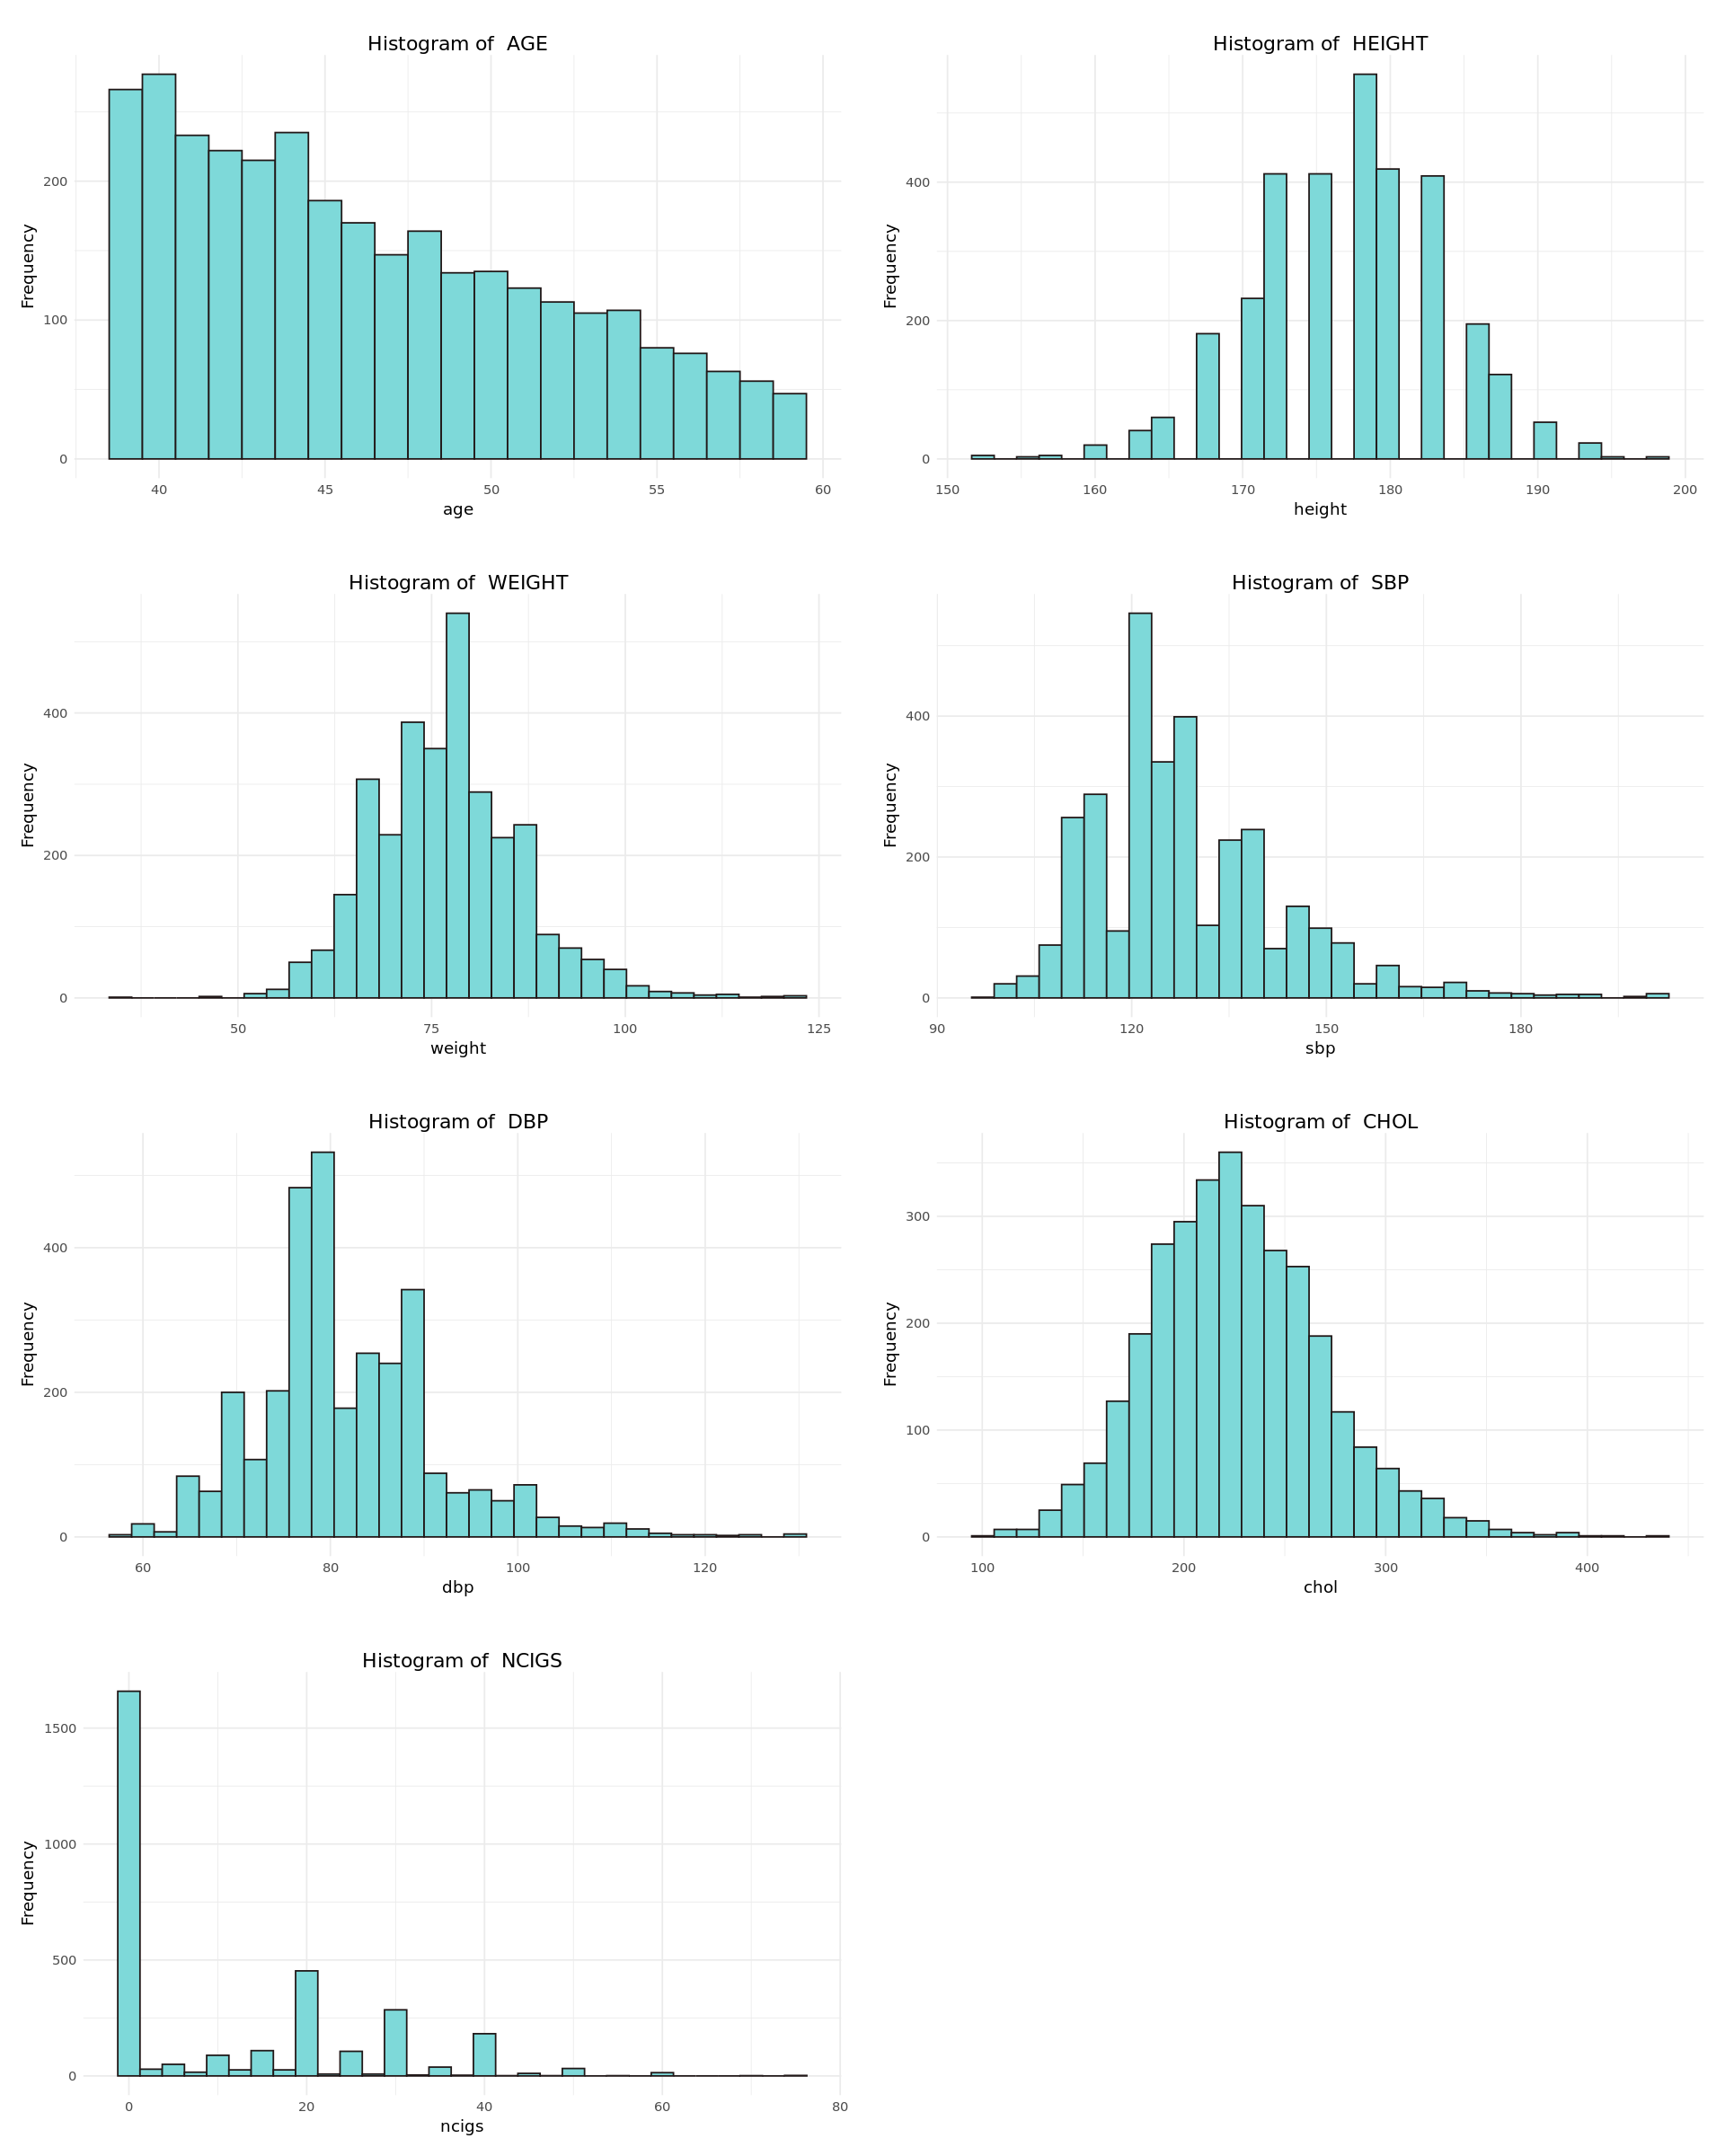

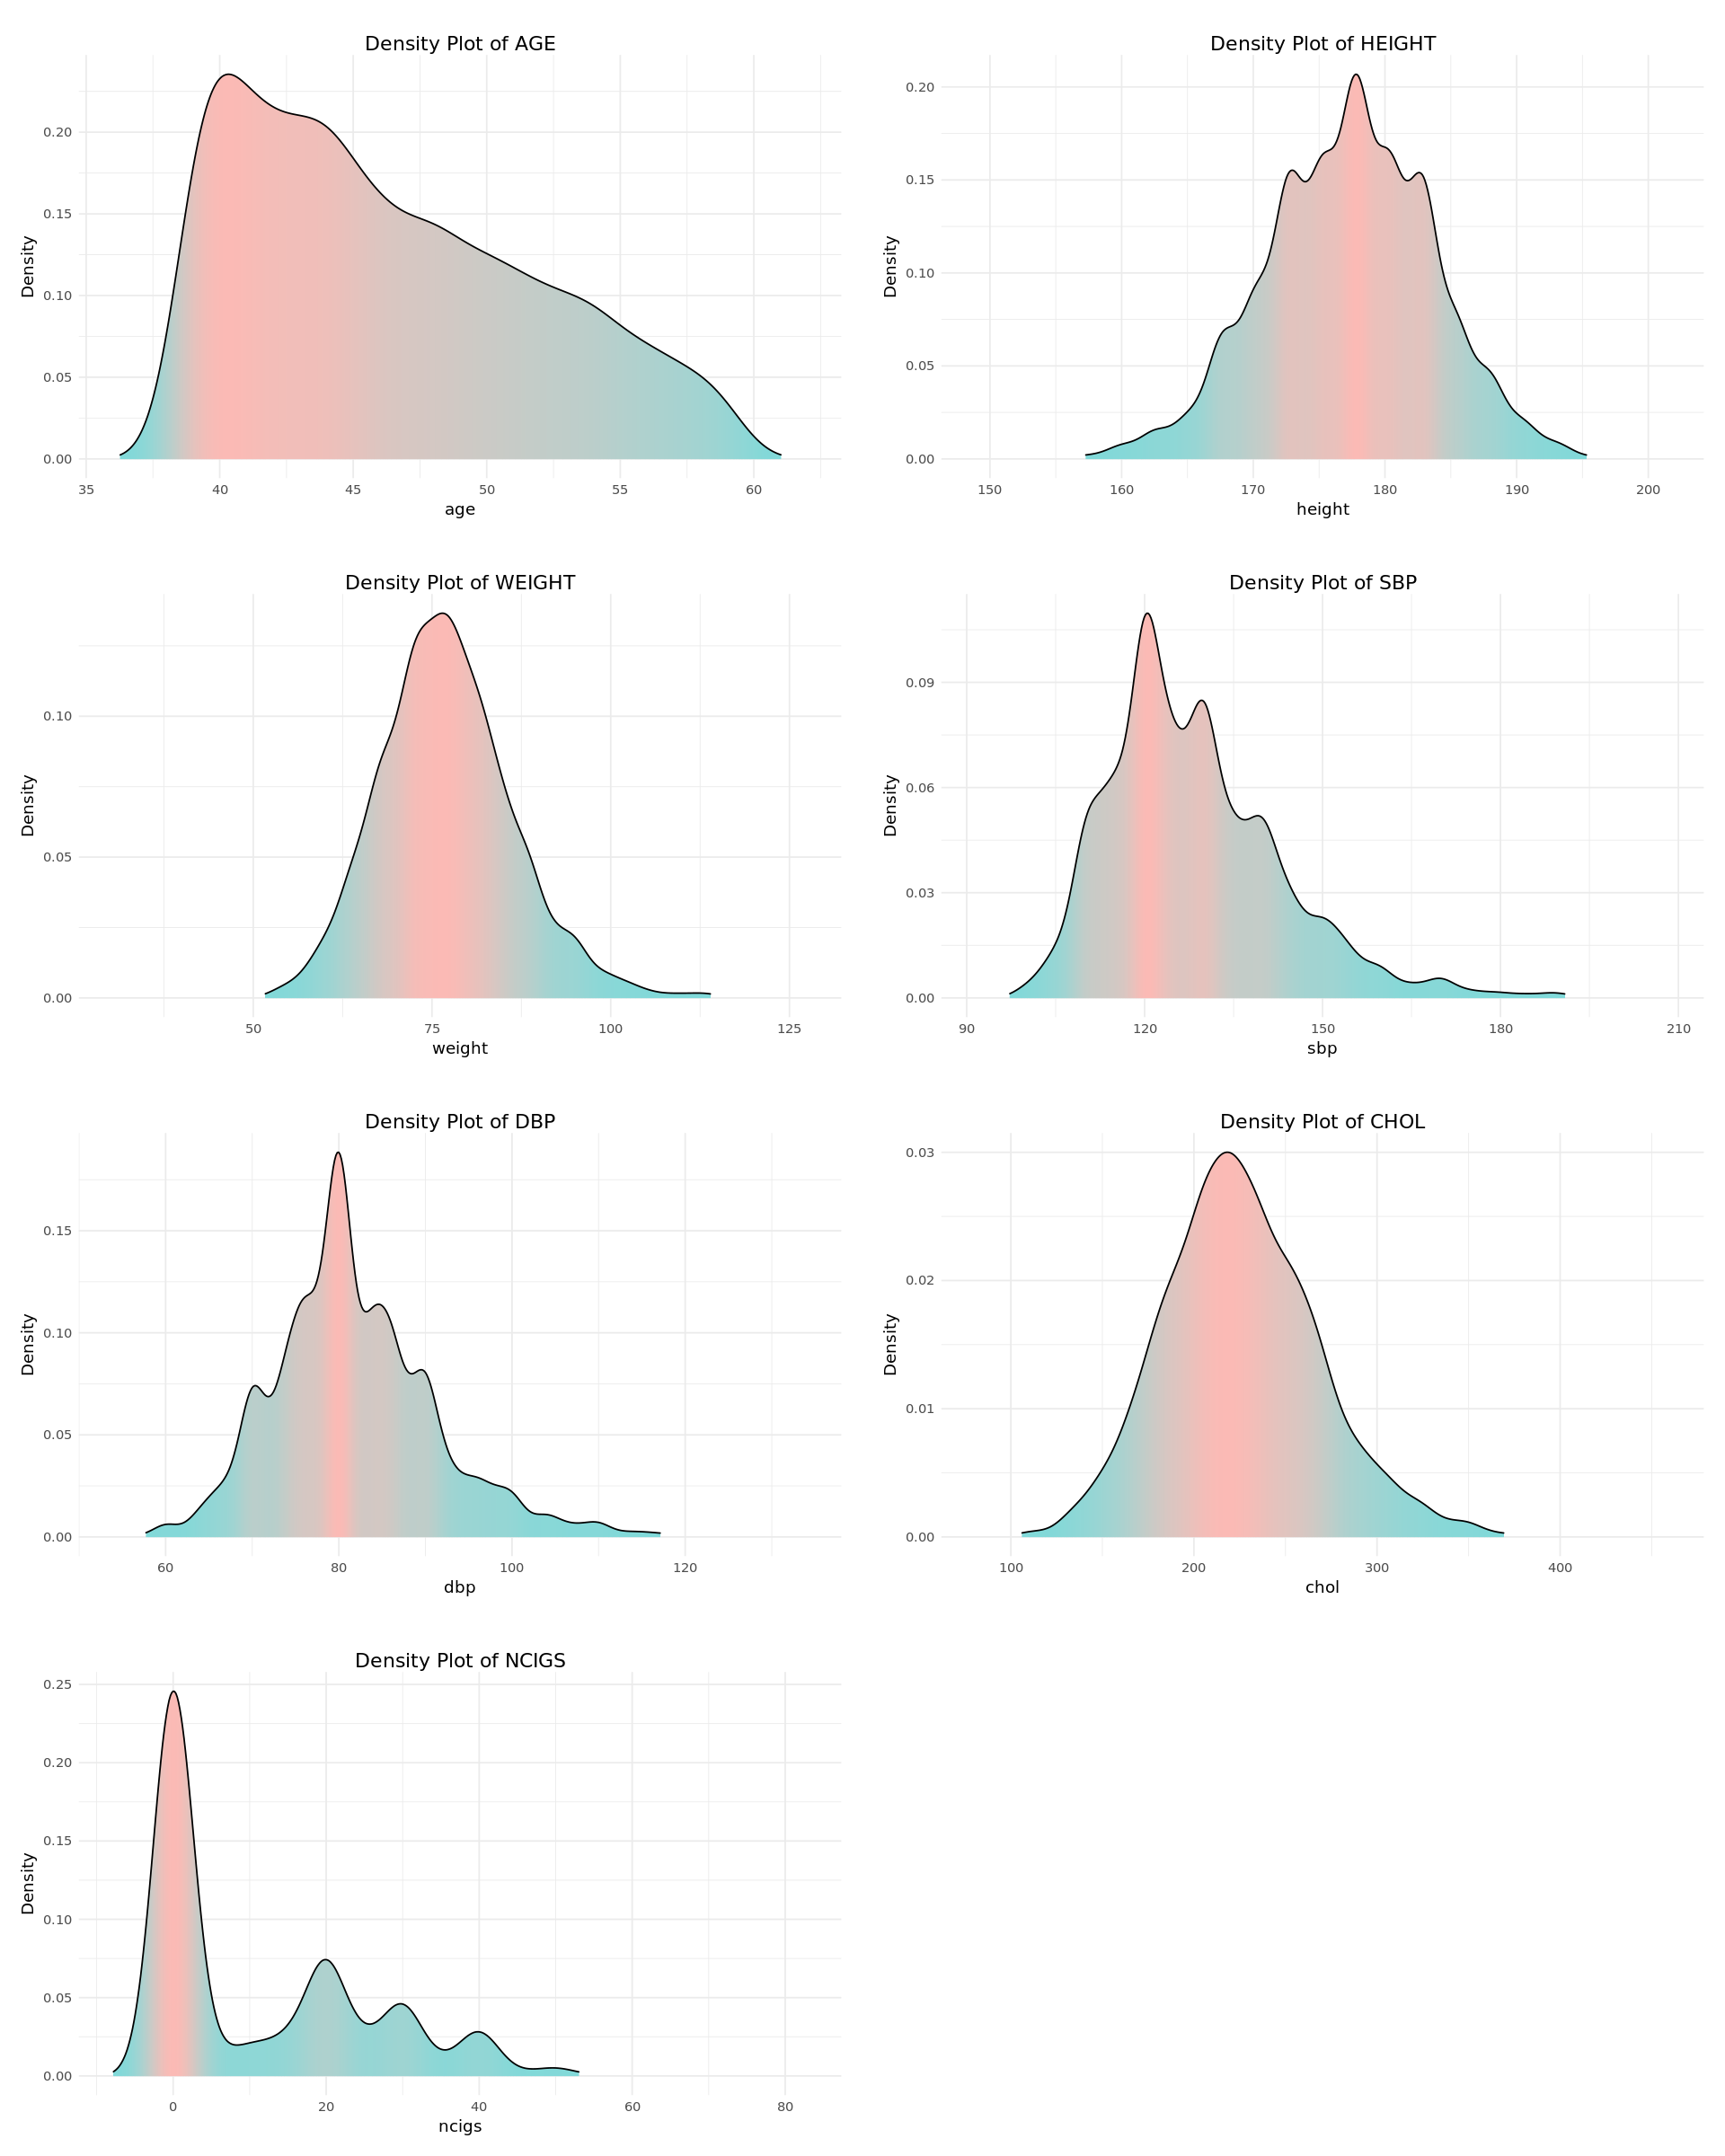

In [18]:
# Set the size of the output plot
options(repr.plot.width = 16, repr.plot.height = 20)

# Generate the histogram for the continuous variables
histograms <- lapply(names(data_fixed)[2:8], function(col) {
  generate_histogram(data_fixed, col)
})

# Generate the density plot for the continuous variables
density_plots <- lapply(names(data_fixed)[2:8], function(col) {
  generate_density_plot(data_fixed, col)
})

# Print the plots in a grid
grid.arrange(grobs = histograms, ncol = 2)
grid.arrange(grobs = density_plots, ncol = 2)


In [43]:
# Assuming data_fixed is your data frame and 'chd' is the binary variable
# Convert 'chd' to numeric if it is not already
data_fixed$chd <- as.numeric(data_fixed$chd)

# Generate the Pearson report for each continuous variable
pearson_report <- lapply(names(data_fixed)[2:ncol(data_fixed)], function(col) {
  generate_pearson_report(data_fixed, col)
})

# Print the Pearson correlation report
print(pearson_report)

[[1]]

	Pearson's product-moment correlation

data:  data[[continuous_var]] and data$chd
t = 6.7439, df = 3152, p-value = 1.827e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.08471402 0.15352589
sample estimates:
      cor 
0.1192632 


[[2]]

	Pearson's product-moment correlation

data:  data[[continuous_var]] and data$chd
t = 1.0584, df = 3152, p-value = 0.2899
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01606341  0.05371536
sample estimates:
       cor 
0.01884893 


[[3]]

	Pearson's product-moment correlation

data:  data[[continuous_var]] and data$chd
t = 3.4658, df = 3152, p-value = 0.0005357
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02677053 0.09630939
sample estimates:
       cor 
0.06161473 


[[4]]

	Pearson's product-moment correlation

data:  data[[continuous_var]] and data$chd
t = 7.6119, df = 3152, p-value = 3.547e-14
a

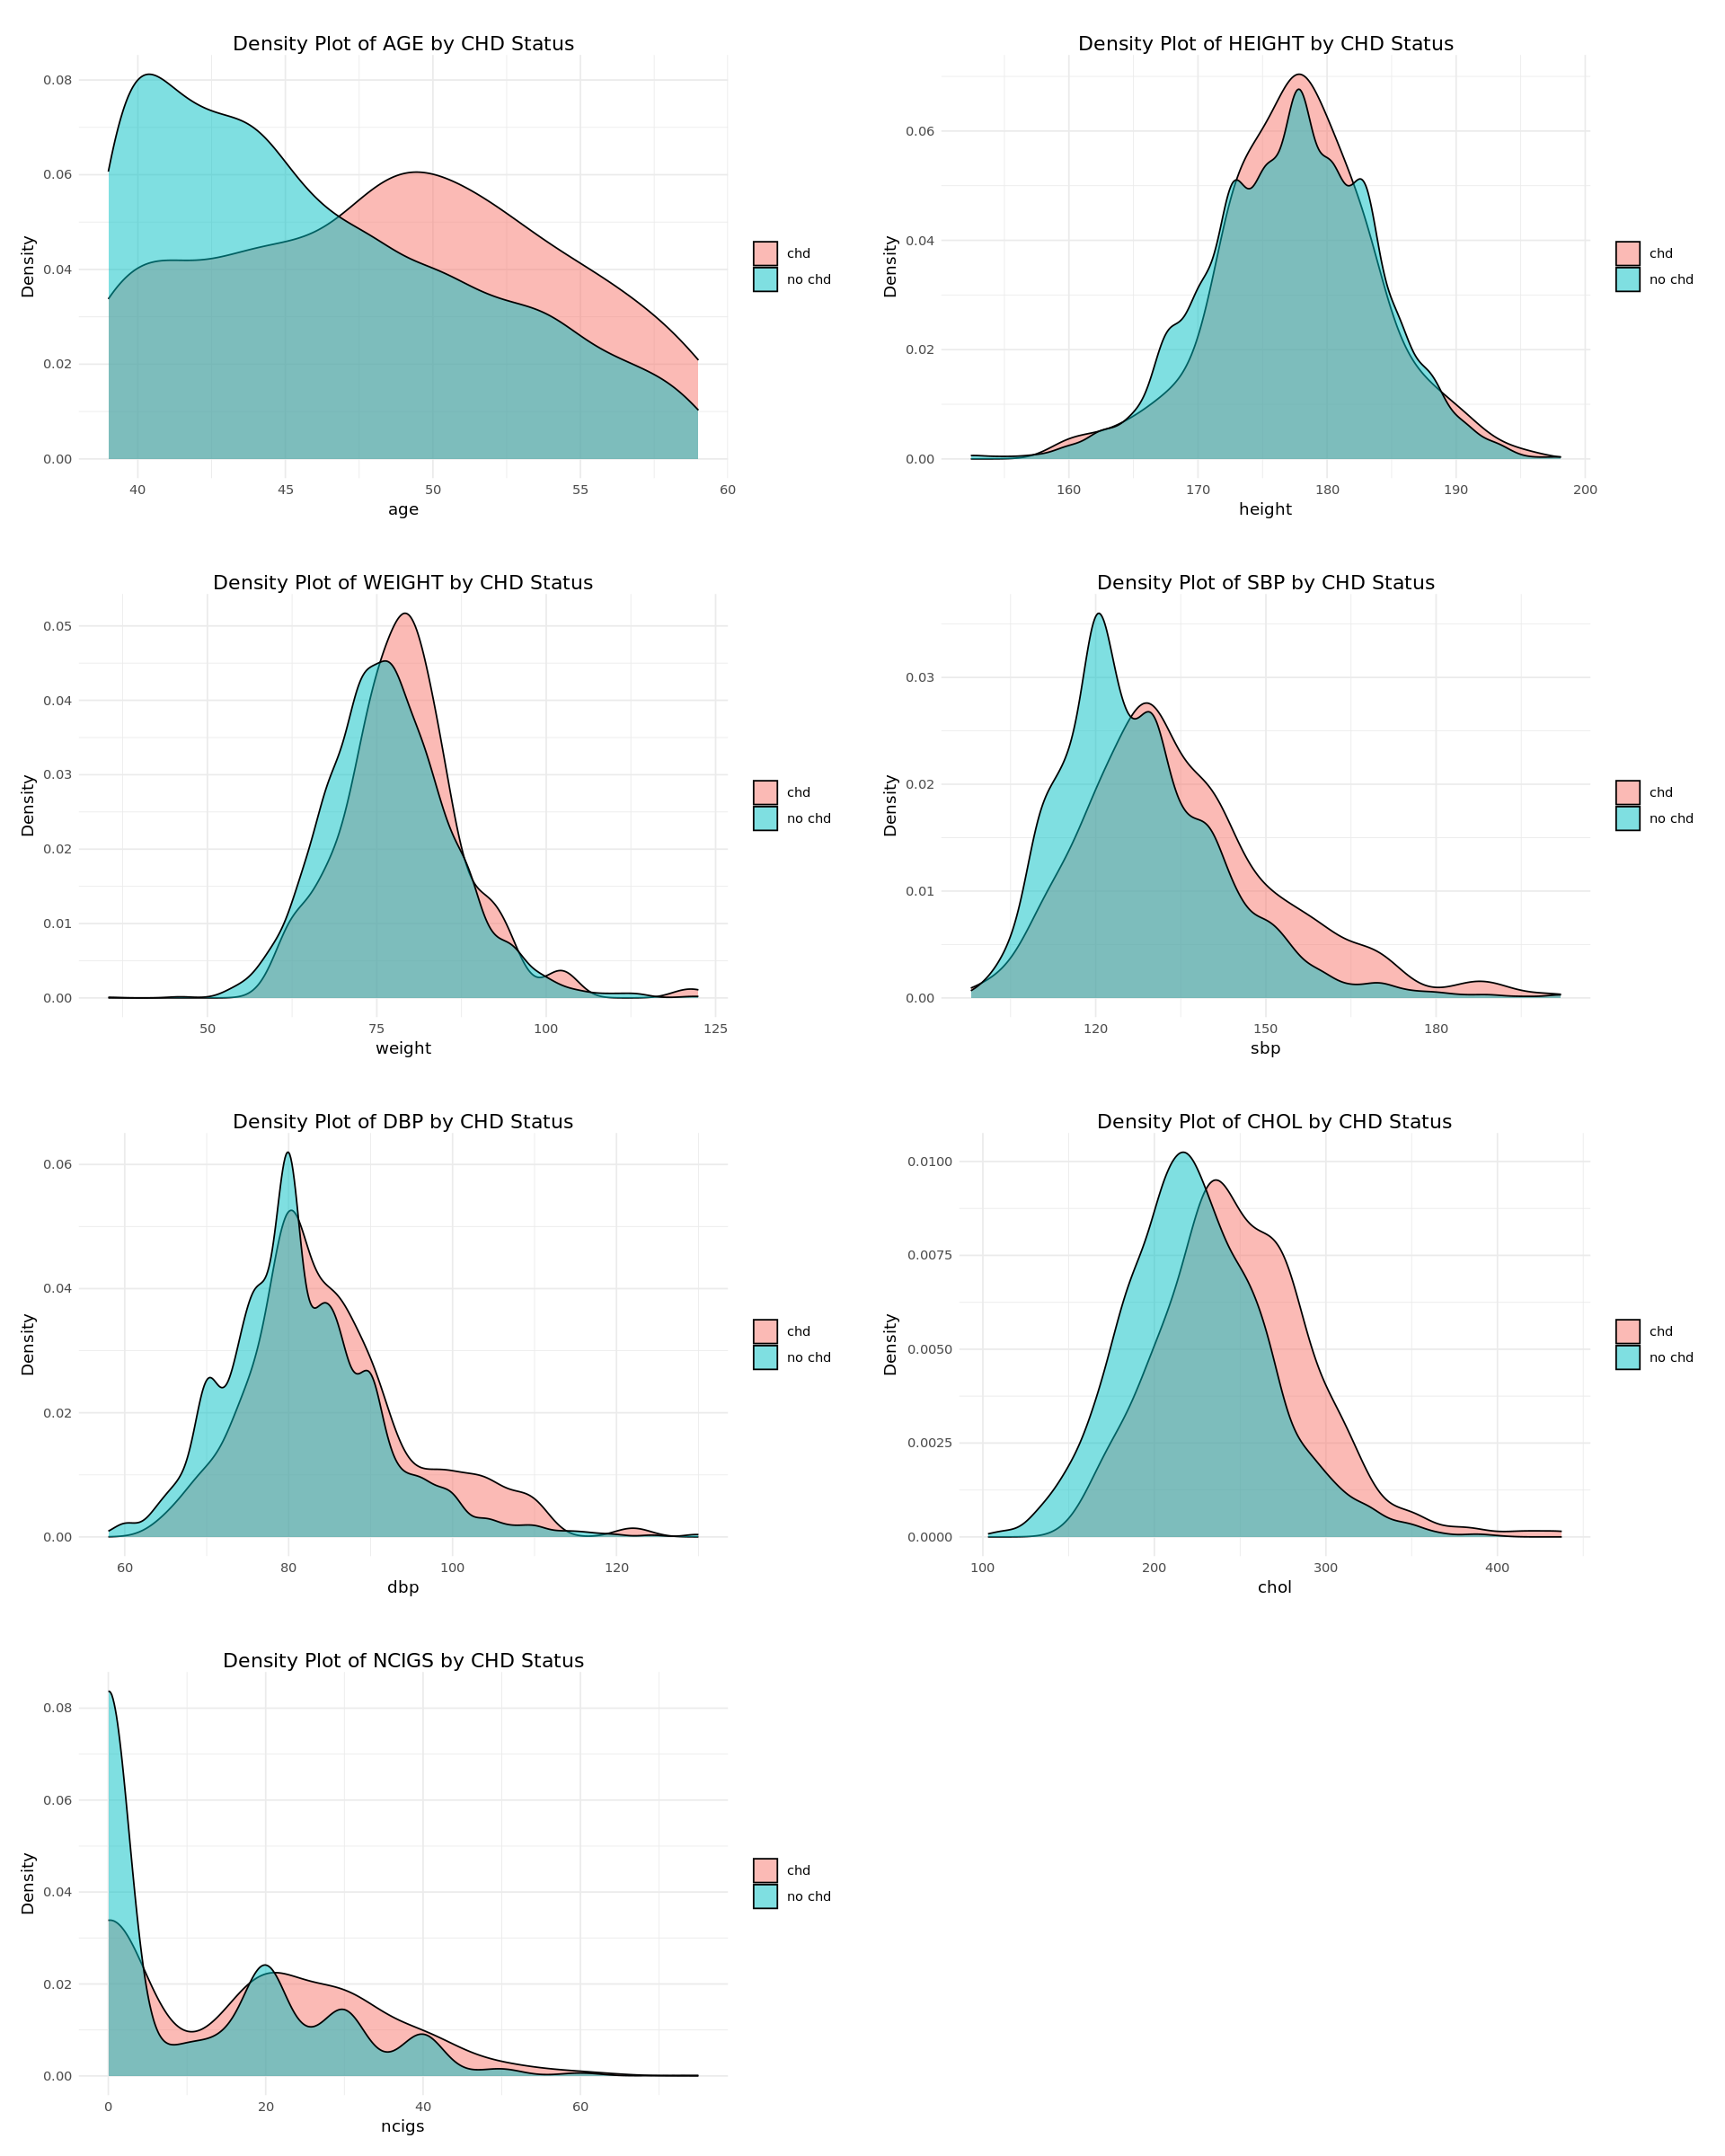

In [21]:
# Generate the overlayed density plot for the continuous variables
density_plots_overlayed <- lapply(names(data_fixed)[2:8], function(col) {
  generate_double_density_plot(data_fixed, col)
})

# Print the overlayed density plots
grid.arrange(grobs = density_plots_overlayed, ncol = 2)

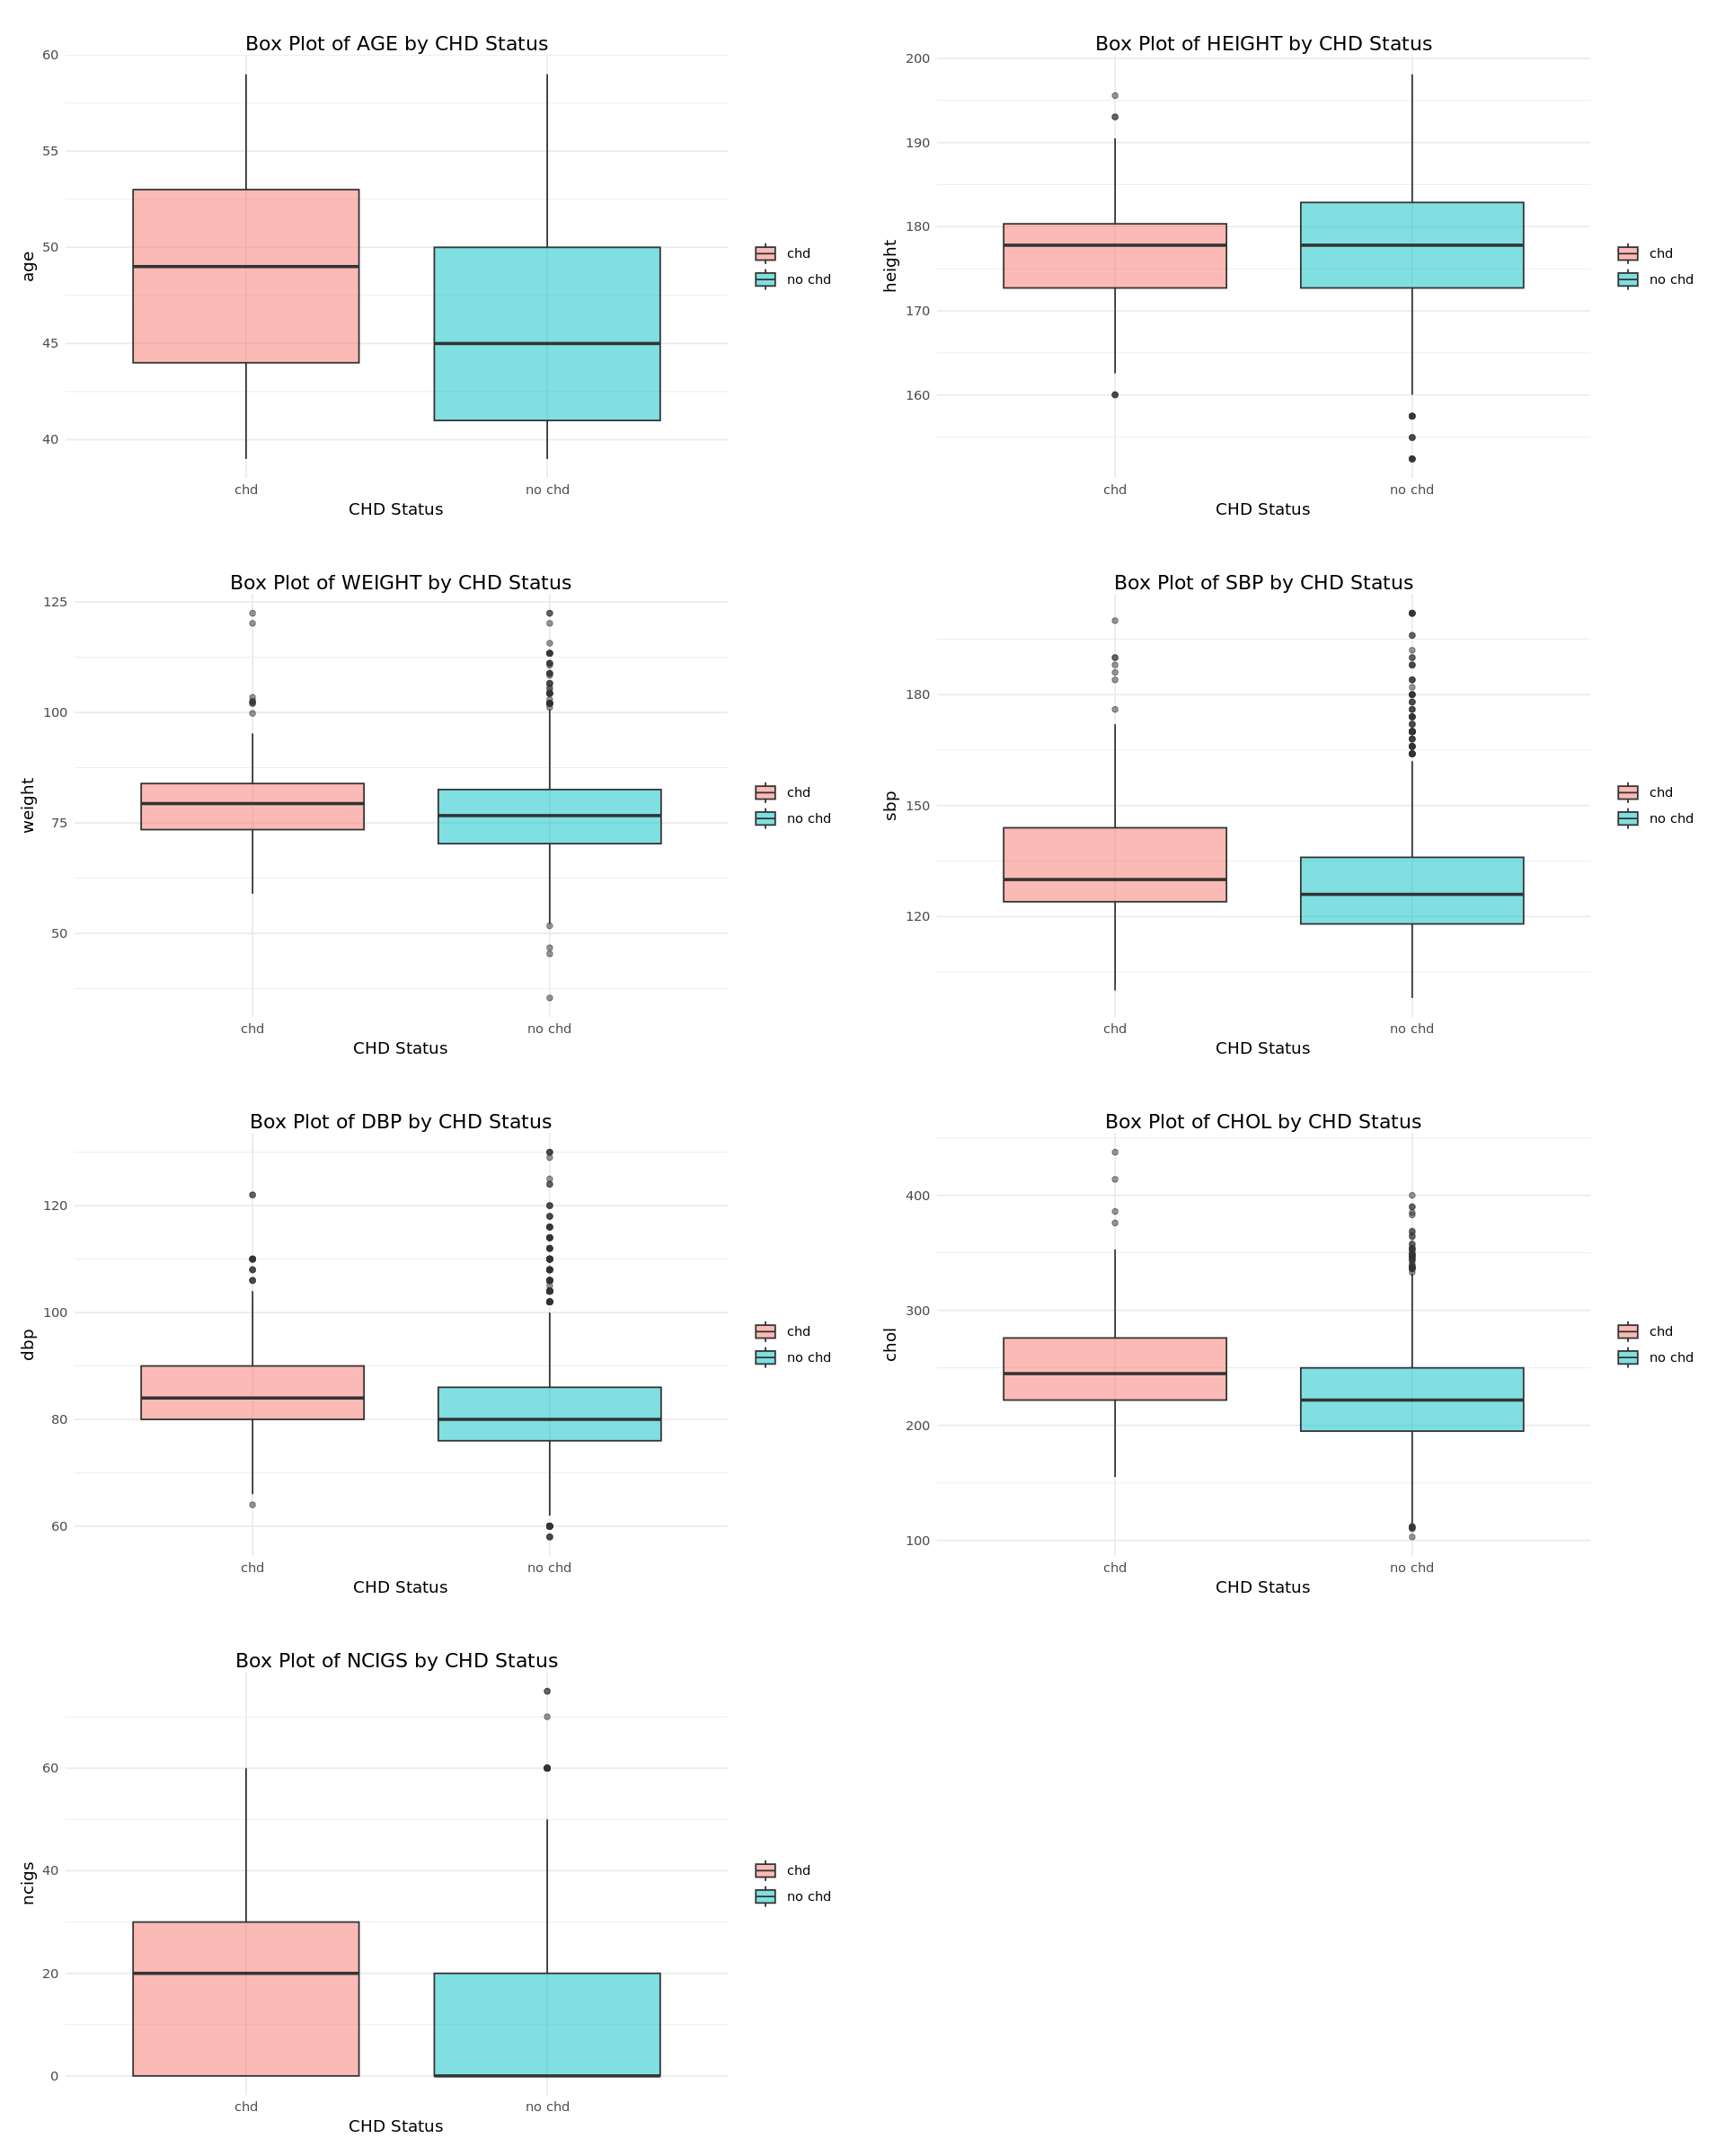

In [22]:
# Generate the overlayed box plot for the continuous variables
boxplots_overlayed <- lapply(names(data_fixed)[2:8], function(col) {
  generate_double_box_plot(data_fixed, col)
})

# Print the overlayed box plots
grid.arrange(grobs = boxplots_overlayed, ncol = 2)

In [23]:
# In this section, I am going to perform logistic regression analysis
# Steps of logistic regression analysis:

# Create the interaction terms I want to study

#   1. age * chol
#   2. age * dbp
#   3. age * ncigs
#   4. age * sbp
#   5. chol * ncigs
#   6. height * weight
#   7. ncigs * dbp
#   8. ncigs * sbp
#   9. sbp * dbp
#  10. weight * chol
#  11. weight * ncigs

# Split the data into training and test sets

# Build the logistic regression model

# Evaluate the model

# Perform multicollinearity analysis

In [24]:
# Functions to perform the logistic regression analysis
library(corrplot)

# Function to create interaction terms
create_interaction_terms <- function(data) {
  data$age_chol <- data$age * data$chol
  data$age_dbp <- data$age * data$dbp
  data$age_ncigs <- data$age * data$ncigs
  data$age_sbp <- data$age * data$sbp
  data$chol_ncigs <- data$chol * data$ncigs
  data$height_weight <- data$height * data$weight
  data$ncigs_dbp <- data$ncigs * data$dbp
  data$ncigs_sbp <- data$ncigs * data$sbp
  data$sbp_dbp <- data$sbp * data$dbp
  data$weight_chol <- data$weight * data$chol
  data$weight_ncigs <- data$weight * data$ncigs

  return(data)
}

# Split the data into training and test sets
split_data <- function(data, train_ratio = 0.7) {
  set.seed(123)
  rownames(data) <- NULL  # Drop row names
  train_indices <- sample(seq_len(nrow(data)), round(nrow(data) * train_ratio))
  train_data <- data[train_indices, ]
  test_data <- data[-train_indices, ]
  return(list(train_data = train_data, test_data = test_data))
}

# Build the logistic regression model
build_regression_model <- function(data) {
  model <- glm(chd ~ ., data = data, family = binomial)
  return(model)
}

# Evaluate the model
evaluate_model <- function(model, test_data) {
  predictions <- predict(model, test_data, type = "response")
  threshold <- 0.5
  predicted_classes <- ifelse(predictions > threshold, 1, 0)
  accuracy <- mean(predicted_classes == test_data$chd)
  return(accuracy)
}

# Perform multicollinearity analysis
multicollinearity_analysis <- function(data) {
  # Check if data is normally distributed
  is_normal <- sapply(data, function(column) {
    shapiro_test <- shapiro.test(column)
    p_value <- shapiro_test$p.value
    return(p_value > 0.05)  # If p-value > 0.05, we assume normal distribution
  })

  # If all columns are normally distributed, use Pearson correlation
  # Otherwise, use Spearman correlation
  method <- if (all(is_normal)) "pearson" else "spearman"

  cor_matrix <- cor(data, method = method)
  corrplot(cor_matrix, method = "number")
}

# Create a function to perform the logistic regression analysis
perform_regression_analysis <- function(data) {
  # Create the interaction terms
  data <- create_interaction_terms(data)

  # Split the data into training and test sets
  split_data <- split_data(data)
  train_data <- split_data$train_data
  test_data <- split_data$test_data

  # Build the logistic regression model
  model <- build_regression_model(train_data)

  # Evaluate the model
  accuracy <- evaluate_model(model, test_data)

  # Perform multicollinearity analysis
  multicollinearity_analysis(data)

  return(accuracy)
}

corrplot 0.92 loaded



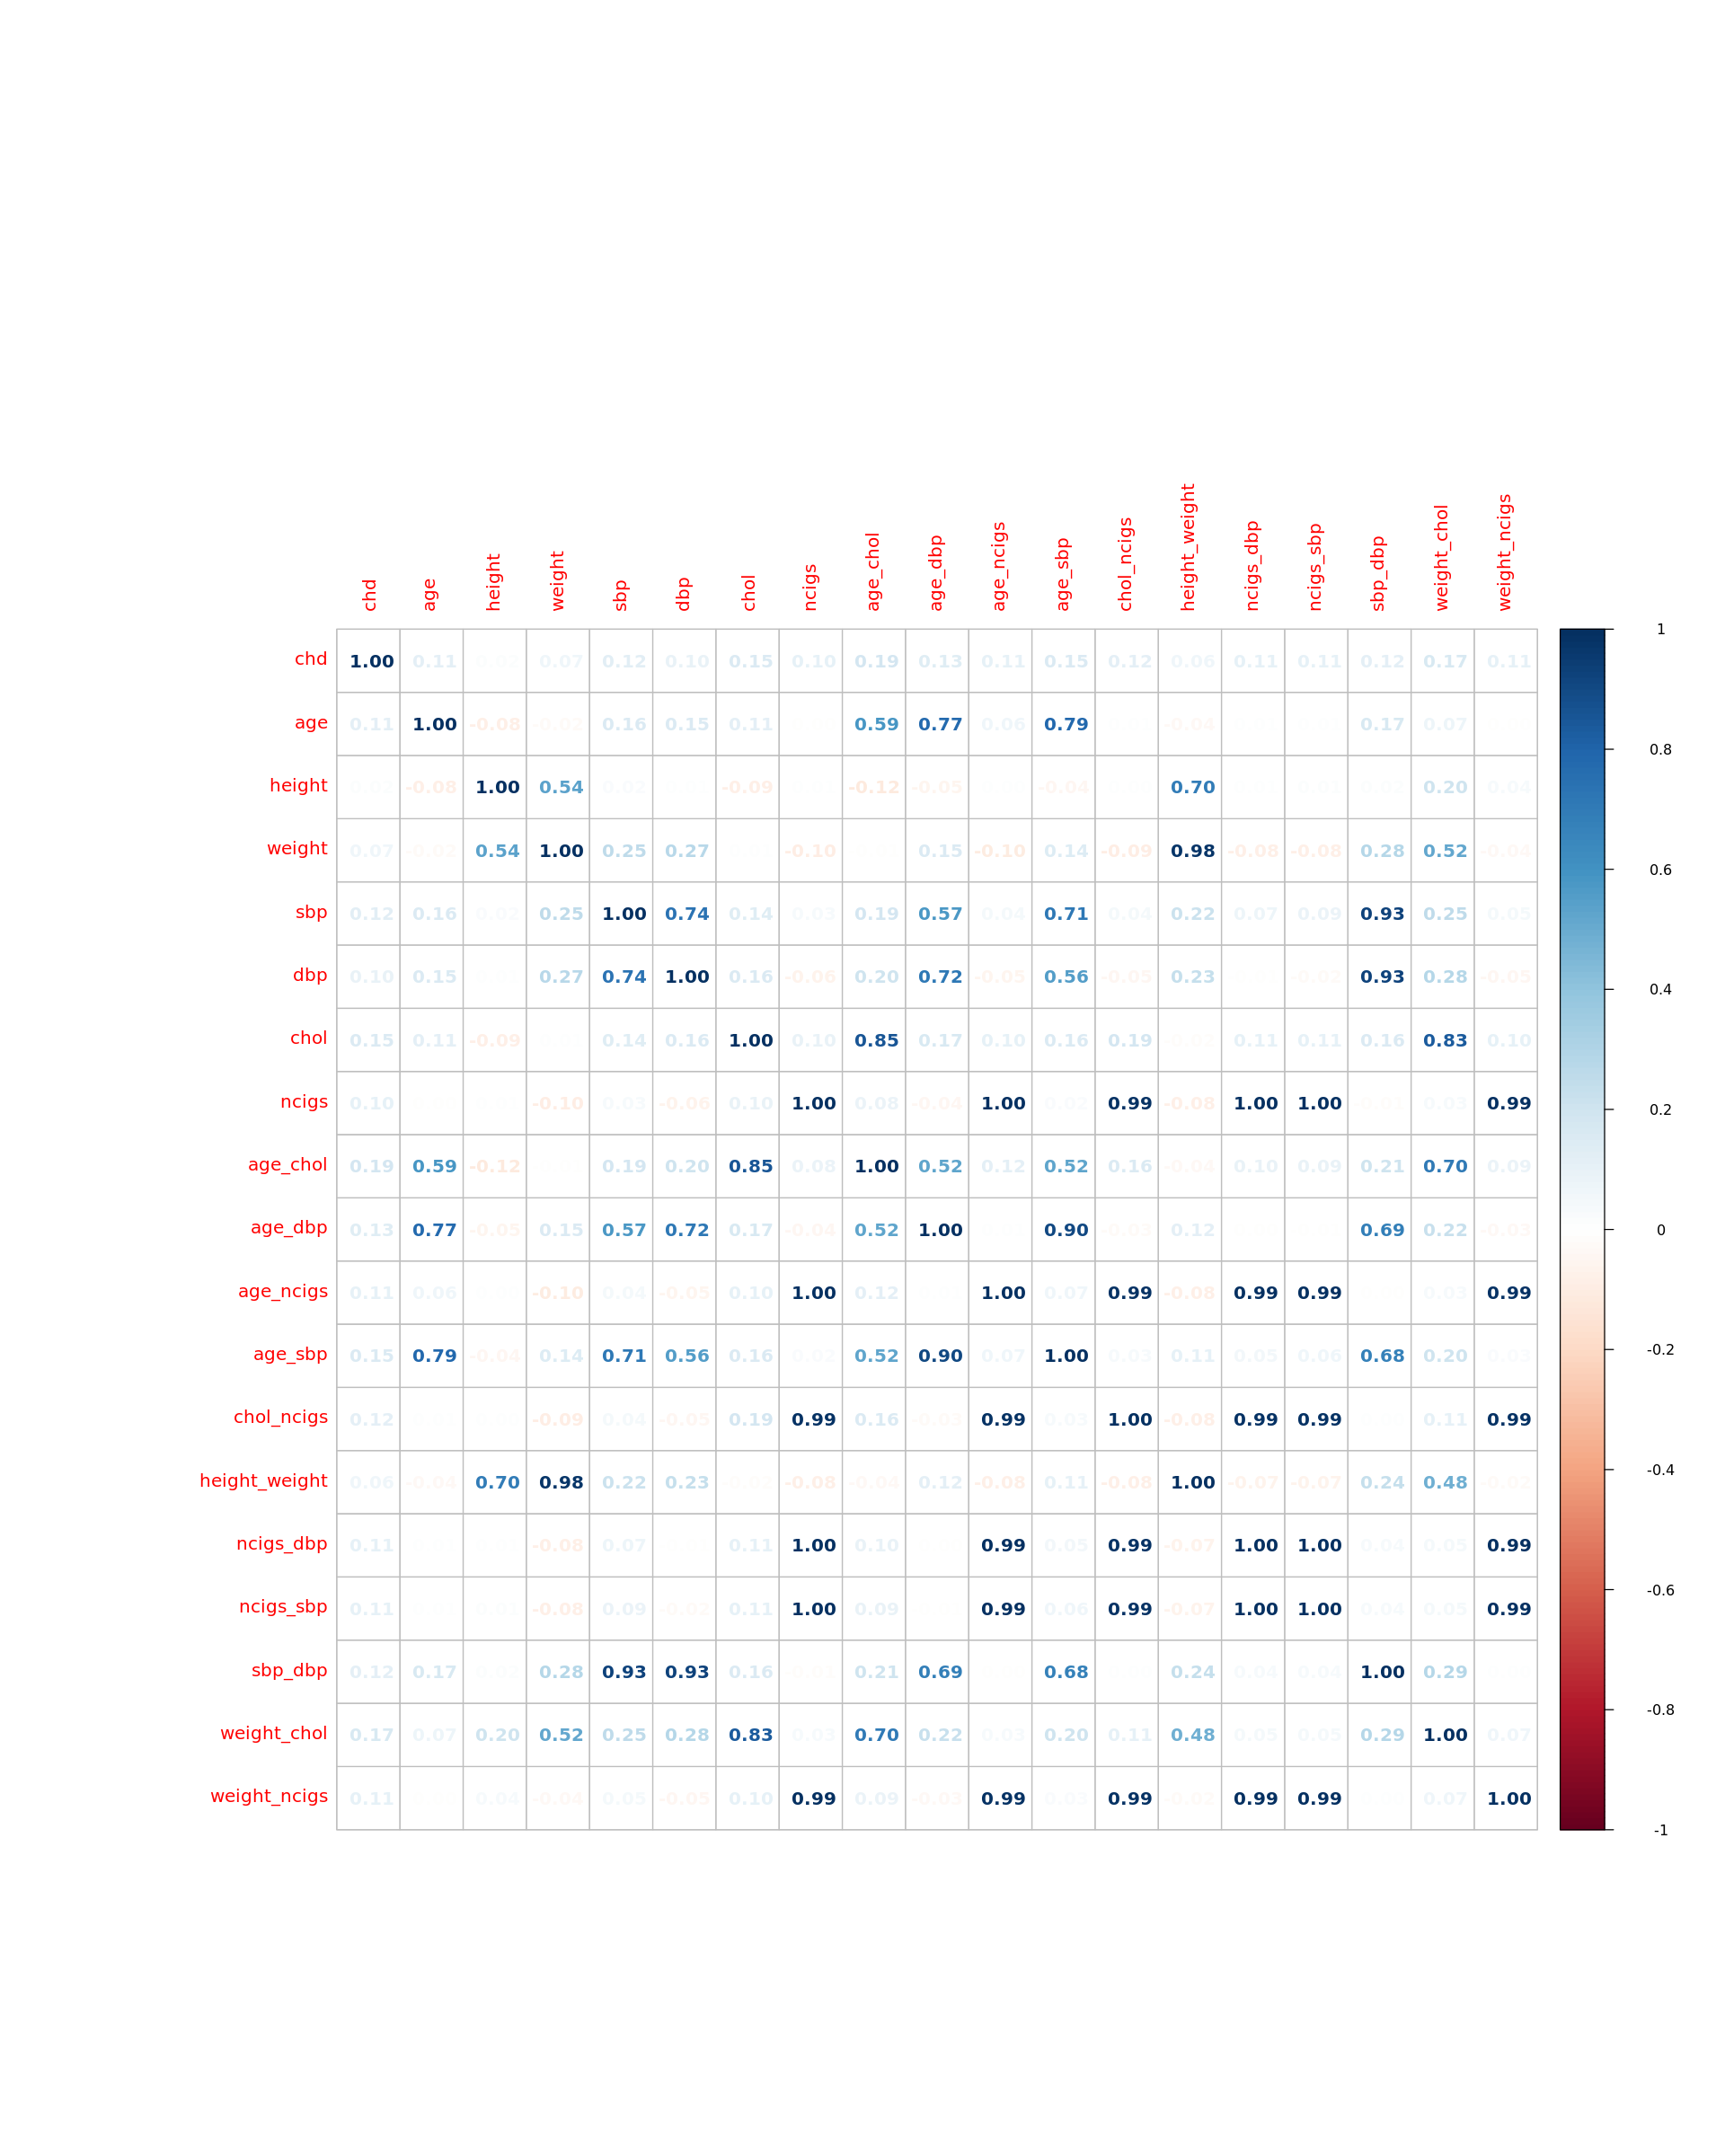

In [25]:
# Perform the logistic regression analysis
accuracy <- perform_regression_analysis(data_fixed)